# Digit Recognizer

## Table of Contents <a id='toc'/>
1. [Imports](#imports)
2. [Configs](#configs)
3. [Utils](#utils)
4. [Data Preparation](#dataprep)
5. [ML Workflow](#ml)
  * [RandomForestClassifier](#rfc)
  * [CNN](#cnn)
6. [Side Analysis](#sideanalysis)

## Imports <a id='imports'/>
[Back to top](#toc)

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

## Configs / Constants <a id='configs'/>
[Back to top](#toc)

In [104]:
TRAIN_DATA_PATH = 'data/train.csv'
TEST_DATA_PATH = 'data/test.csv'
PREDICTION_DATA_PATH = 'data/submission.csv'

LABEL = 'Label'
IMAGE_ID = 'ImageId'
IMAGE_N_DIMS = 28
N_CLASSES = 10

N_JOBS = 4
N_TREES_RFC = 1000

BATCH_SIZE = 64
N_EPOCHS = 20
INPUT_SHAPE = (IMAGE_N_DIMS, IMAGE_N_DIMS, 1)
N_FILTERS_1 = 32
N_FILTERS_2 = 64
N_FILTERS_3 = 128
KERNEL_SIZE_CONV = (3, 3)
DROPOUT_1 = 0.2
DROPOUT_2 = 0.25
RELU = 'relu'
SOFTMAX = 'softmax'
KERNEL_INIT = 'he_normal'
PADDING_SAME = 'same'
POOL_SIZE = (2, 2)
N_DENSE = 128

CMAP_BIN = 'binary'

## Utils Classes & Functions <a id='utils'/>
[Back to top](#toc)

In [120]:
### Predicting & saving output based on input X ###
def predict_save(estimator, X):
    if type(estimator) == keras.engine.sequential.Sequential:
        Y_pred = estimator.predict_classes(X)
    else:
        Y_pred = estimator.predict(X)
    Y_pred_df = pd.DataFrame(Y_pred, columns=[LABEL])
    Y_pred_df[IMAGE_ID] = Y_pred_df.index + 1
    Y_pred_df[[IMAGE_ID, LABEL]].to_csv(PREDICTION_DATA_PATH, index=False)
    return Y_pred

## Data Preparation <a id='dataprep'/>
[Back to top](#toc)

In [2]:
%%time
### Read data from source data files ###
df = pd.read_csv(TRAIN_DATA_PATH)
tdf = pd.read_csv(TEST_DATA_PATH)

### Forming Xs & Ys ###
X_train = df.iloc[:, 1:]
Y_train = df.iloc[:, 0]
X_test = tdf

Wall time: 4.79 s


In [89]:
%%time
### Normalizing data ###
X_train_norm = X_train / 255
X_test_norm = X_test / 255

### Reshaping to CNN input layer ###
X_train_cnn = X_train_norm.values.reshape(-1, *INPUT_SHAPE)
X_test_cnn = X_test_norm.values.reshape(-1, *INPUT_SHAPE)

### Transforming Y ###
Y_train_cnn = keras.utils.to_categorical(Y_train, N_CLASSES)

(42000, 28, 28, 1)
Wall time: 2.9 s


## Machine Learning Workflow <a id='ml'/>
[Back to top](#toc)

### RandomForestClassifier <a id='rfc'/>
Kaggle Score: 0.96742

In [4]:
%%time
### RandomForestClassifier ###
rfc = RandomForestClassifier(n_estimators=N_TREES_RFC, n_jobs=N_JOBS)
rfc.fit(X_train, Y_train)
Y_pred = predict_save(estimator=rfc, X=X_test)

Wall time: 1min 40s


### Keras Model 1 <a id='cnn'/>
Kaggle Score: 0.99400

In [110]:
%%time
### CNN ###
cnn_model = Sequential()

cnn_model.add(
    Conv2D(
        filters=N_FILTERS_1, 
        kernel_size=KERNEL_SIZE_CONV, 
        activation=RELU, 
        kernel_initializer=KERNEL_INIT, 
        input_shape=INPUT_SHAPE
    )
)
cnn_model.add(
    Conv2D(
        filters=N_FILTERS_1,
        kernel_size=KERNEL_SIZE_CONV,
        activation=RELU,
        kernel_initializer=KERNEL_INIT
    )
)
cnn_model.add(
    MaxPool2D(
        pool_size=POOL_SIZE
    )
)
cnn_model.add(
    Dropout(rate=DROPOUT_1)
)
cnn_model.add(
    Conv2D(
        filters=N_FILTERS_2, 
        kernel_size=KERNEL_SIZE_CONV, 
        padding=PADDING_SAME, 
        activation=RELU, 
        kernel_initializer=KERNEL_INIT
    )
)
cnn_model.add(
    Conv2D(
        filters=N_FILTERS_2,
        kernel_size=KERNEL_SIZE_CONV,
        padding=PADDING_SAME,
        activation=RELU,
        kernel_initializer=KERNEL_INIT
    )
)
cnn_model.add(
    MaxPool2D(
        pool_size=POOL_SIZE
    )
)
cnn_model.add(
    Dropout(
        rate=DROPOUT_2
    )
)
cnn_model.add(
    Conv2D(
        filters=N_FILTERS_3, 
        kernel_size=KERNEL_SIZE_CONV, 
        padding=PADDING_SAME, 
        activation=RELU, 
        kernel_initializer=KERNEL_INIT
    )
)
cnn_model.add(
    Dropout(
        rate=DROPOUT_2
    )
)
cnn_model.add(
    Flatten()
)
cnn_model.add(
    Dense(
        units=N_DENSE, 
        activation=RELU
    )
)
cnn_model.add(
    BatchNormalization()
)
cnn_model.add(
    Dropout(
        rate=DROPOUT_2
    )
)
cnn_model.add(
    Dense(
        units=N_CLASSES, 
        activation=SOFTMAX
    )
)

cnn_model.compile(
    optimizer=Adam(), 
    loss=categorical_crossentropy, 
    metrics=['accuracy']
)

cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [112]:
%%time
cnn_model.fit(x=X_train_cnn, y=Y_train_cnn, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
42000/42000 [==============================] - 137s 3ms/step - loss: 0.1947 - acc: 0.9386
Epoch 2/20
42000/42000 [==============================] - 125s 3ms/step - loss: 0.0627 - acc: 0.9803
Epoch 3/20
42000/42000 [==============================] - 99s 2ms/step - loss: 0.0466 - acc: 0.9852
Epoch 4/20
42000/42000 [==============================] - 99s 2ms/step - loss: 0.0404 - acc: 0.9872
Epoch 5/20
42000/42000 [==============================] - 103s 2ms/step - loss: 0.0339 - acc: 0.9895
Epoch 6/20
42000/42000 [==============================] - 109s 3ms/step - loss: 0.0312 - acc: 0.9900
Epoch 7/20
42000/42000 [==============================] - 108s 3ms/step - loss: 0.0284 - acc: 0.9906
Epoch 8/20
42000/42000 [==============================] - 110s 3ms/step - loss: 0.0249 - acc: 0.9917
Epoch 9/20
42000/42000 [==============================] - 111s 3ms/step - loss: 0.0222 - acc: 0.9929
Epoch 10/20
42000/42000 [====================

In [121]:
%%time
predict_save(estimator=cnn_model, X=X_test_cnn)

Wall time: 23.4 s


array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [124]:
%%time
cnn_model.save('data/cnn_model_v0_1.h5')

Wall time: 400 ms


## Side Analysis <a id='sideanalysis'>
[Back to top](#toc)

Training Data & Outcome


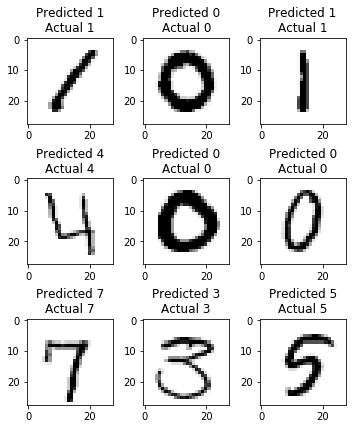

Wall time: 13.4 s


In [62]:
%%time
### Training Data Outcome ###
Y_train_pred = rfc.predict(X_train)

print('Training Data & Outcome')
fig, axes = plt.subplots(3, 3, figsize=(5, 6))

for i, axis in enumerate(axes.flat):
    axis.imshow(X_train.iloc[i].values.reshape(IMAGE_N_DIMS, IMAGE_N_DIMS), cmap=CMAP_BIN)
    axis.set_title('Predicted {}\nActual {}'.format(Y_train_pred[i], Y_train[i]))
fig.tight_layout()
plt.show()

Testing Data & Outcome


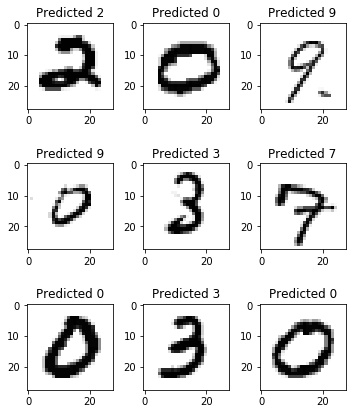

Wall time: 2.5 s


In [63]:
%%time
### Testing Data Outcome ###
print('Testing Data & Outcome')
fig, axes = plt.subplots(3, 3, figsize=(5, 6))

for i, axis in enumerate(axes.flat):
    axis.imshow(X_test.iloc[i].values.reshape(IMAGE_N_DIMS, IMAGE_N_DIMS), cmap=CMAP_BIN)
    axis.set_title('Predicted {}'.format(Y_pred[i]))
fig.tight_layout()
plt.show()